In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import STL
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, awesome_oscillator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
import warnings
warnings.filterwarnings('ignore')

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


Bad key "text.kerning_factor" on line 4 in
C:\Users\Pranav\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def plot_ohlc(df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Ohlc(x=df.index,
                          open=df.Open,
                          high=df.High,
                          low=df.Low,
                          close=df.Close,
                          name='Price'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df.index, y=df.Volume, name='Volume'), row=2, col=1)

    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

def plot_decomposed_close_data(df):
    data = azn_df[['Close']].copy()
    res = STL(data, period=365).fit()
    fig = res.plot()
    fig.set_size_inches(20, 8)
    
def plot_moving_averages(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df.EMA_9, name='EMA 9'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_5, name='SMA 5'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_10, name='SMA 10'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_15, name='SMA 15'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_30, name='SMA 30'))
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close', opacity=0.2))
    fig.show()
    
def plot_RSI(df):
    fig = go.Figure(go.Scatter(x=df.index, y=df.RSI, name='RSI'))
    fig.show()
    
def plot_MACD(df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], name='MACD'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD Signal'], name='Signal line'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close'), row=2, col=1)
    fig.show()
    
def plot_train_test_data(train_df, valid_df, test_df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
    fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
    fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
    fig.show()
    
def plot_predictions(predicted_prices, df, column):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df[column],
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices[column],
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)

    fig.show()
    
def plot_high_low_predictions(predicted_prices, df):
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.High,
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices.High,
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)

    fig.show()
    
def get_moving_averages(df):
    df_sma = SMAIndicator(close=df['Close'], window=5)
    df['SMA_5'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=10)
    df['SMA_10'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=15)
    df['SMA_15'] = df_sma.sma_indicator()
    df_sma = SMAIndicator(close=df['Close'], window=30)
    df['SMA_30'] = df_sma.sma_indicator()
    df_ema = EMAIndicator(close=df['Close'], window=9)
    df['EMA_9'] = df_ema.ema_indicator()
    df.dropna(inplace=True)
    
def get_RSI(df):
    df_rsi = RSIIndicator(close=df['Close'], window=14)
    df['RSI'] = df_rsi.rsi()
    df.dropna(inplace=True)
    
def get_MACD(df):
    macd = MACD(close=df['Close'])
    df['MACD'] = macd.macd()
    df['MACD Signal'] = macd.macd_signal()
    df.dropna(inplace=True)

In [3]:
start = dt.datetime(2017,1,1)
end = dt.datetime.now()
tickers = ['PFE', 'MRNA', 'JNJ', 'AZN', 'BTC-USD','ETH-USD']

filenames = []

for ticker in tickers:
    if ticker == 'MRNA':
        df = yf.download(ticker, dt.datetime(2018,12,7), end)
    else:
        df = yf.download(ticker, start, end)
    filename = f'{ticker}_stock_prices.csv'
    filenames.append(filename)
    df.to_csv(filename)
    
for filename in filenames:
    if filename.startswith('AZN'):
        azn_df = pd.read_csv('AZN_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('BTC-USD'):
        btc_df = pd.read_csv('BTC-USD_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('ETH-USD'):
        eth_df = pd.read_csv('ETH-USD_stock_prices.csv', index_col='Date', parse_dates=True)    
    elif filename.startswith('MRNA'):
        mrna_df = pd.read_csv('MRNA_stock_prices.csv', index_col='Date', parse_dates=True)
    elif filename.startswith('JNJ'):
        jnj_df = pd.read_csv('JNJ_stock_prices.csv', index_col='Date', parse_dates=True)
    else:
        pfe_df = pd.read_csv('PFE_stock_prices.csv', index_col='Date', parse_dates=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
eth_df.head()

Open      High      Low     Close  Adj Close    Volume
Date                                                                  
2017-01-01   7.98231   8.47123  7.98231   8.17257    8.17257  14731700
2017-01-02   8.17087   8.43633  8.05441   8.37851    8.37851  14579600
2017-01-03   8.37458   9.99680  8.31717   9.72525    9.72525  33625200
2017-01-04   9.70929  11.27640  9.55981  11.25160   11.25160  41051200
2017-01-05  11.28680  11.89090  9.40268  10.25440   10.25440  41557400

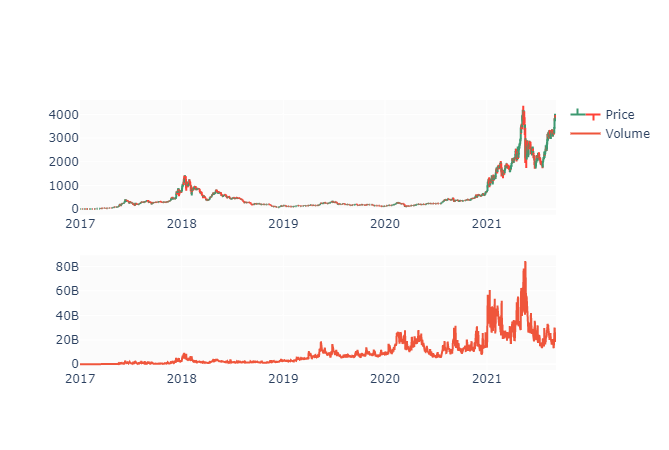

In [5]:
# Get OHLC chart for ETH

plot_ohlc(eth_df)

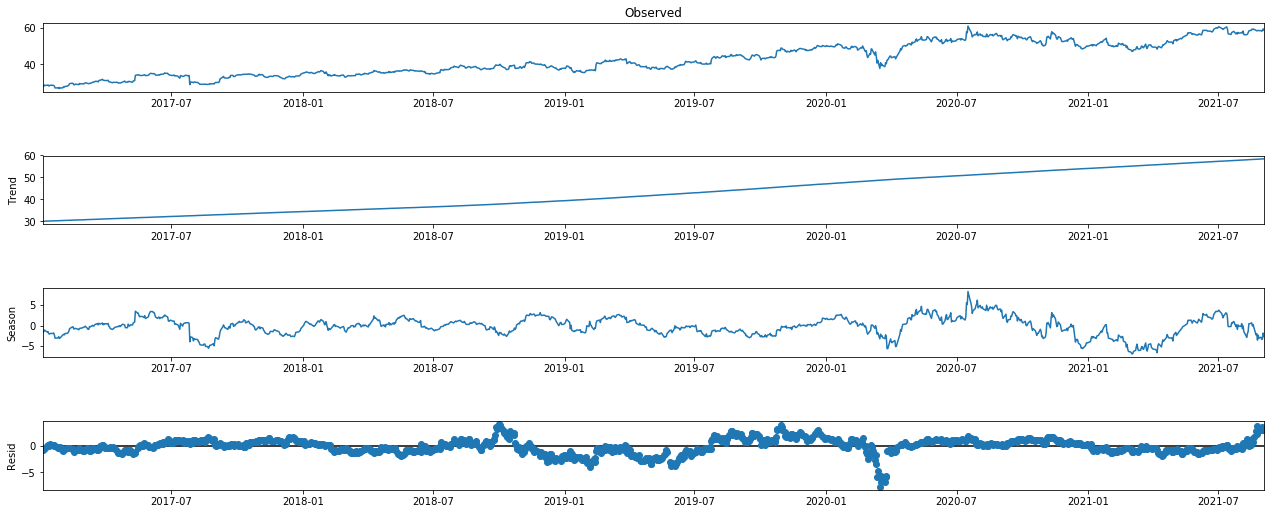

In [6]:
# Decomposing close price for ETH

plot_decomposed_close_data(eth_df)

In [7]:
get_moving_averages(eth_df)
eth_df.head()

Open     High      Low    Close  Adj Close    Volume     SMA_5  \
Date                                                                            
2017-01-30  10.4938  10.7140  10.4665  10.5712    10.5712   8042180  10.54932   
2017-01-31  10.5642  10.7487  10.5450  10.7275    10.7275  11648700  10.57700   
2017-02-01  10.7413  10.8472  10.5566  10.7321    10.7321  12852200  10.61596   
2017-02-02  10.7355  10.8881  10.5519  10.8214    10.8214  10172500  10.66724   
2017-02-03  10.8125  11.1145  10.7550  11.1145    11.1145  12897800  10.79334   

              SMA_10     SMA_15     SMA_30      EMA_9  
Date                                                   
2017-01-30  10.63828  10.503147  10.183864  10.537962  
2017-01-31  10.62011  10.575880  10.269029  10.575869  
2017-02-01  10.62300  10.604533  10.347482  10.607115  
2017-02-02  10.62306  10.644107  10.384020  10.649972  
2017-02-03  10.67126  10.691927  10.379450  10.742878

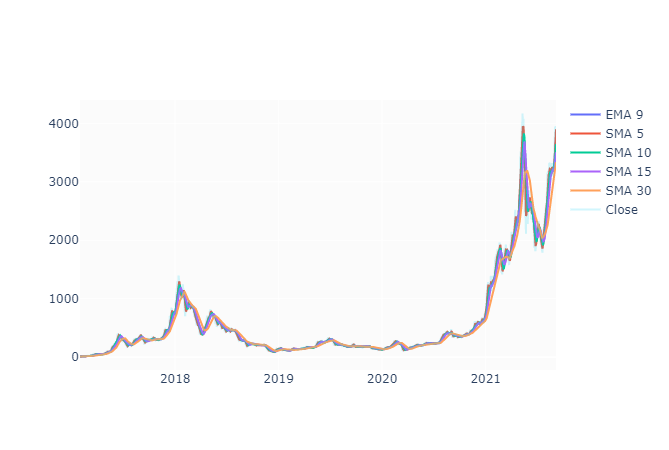

In [8]:
# Plotting Moving Averages for ETH

plot_moving_averages(eth_df)

In [9]:
get_RSI(eth_df)
eth_df.head()

Open     High      Low    Close  Adj Close    Volume     SMA_5  \
Date                                                                            
2017-02-12  11.3533  11.4013  11.3040  11.3992    11.3992   6264900  11.29820   
2017-02-13  11.3836  11.3949  11.1741  11.2695    11.2695   7216520  11.26586   
2017-02-14  11.2864  13.3307  11.2864  13.0252    13.0252  42911500  11.66446   
2017-02-15  13.0397  13.0397  12.6371  12.9197    12.9197  18464700  11.99262   
2017-02-16  12.9210  12.9210  12.5447  12.9037    12.9037  38002600  12.30346   

              SMA_10     SMA_15     SMA_30      EMA_9        RSI  
Date                                                              
2017-02-12  11.32967  11.108860  10.755861  11.259108  67.024628  
2017-02-13  11.34517  11.161227  10.809955  11.261187  60.538646  
2017-02-14  11.50434  11.324827  10.913987  11.613989  83.630737  
2017-02-15  11.66101  11.470973  11.023427  11.875131  80.579313  
2017-02-16  11.81244  11.615747  11.110140  12.080845  80.101976

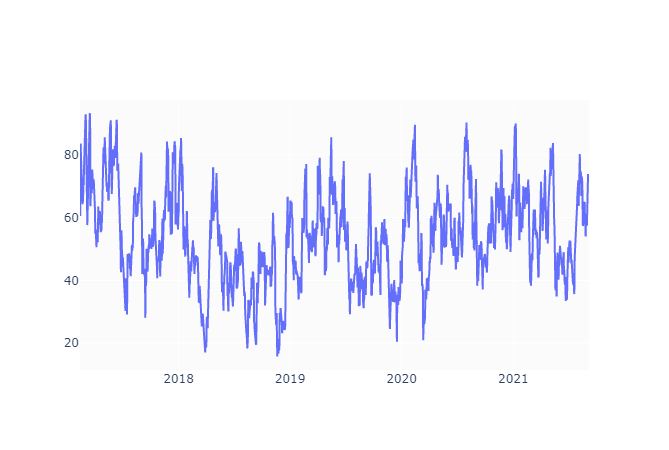

In [10]:
# Plotting RSI 

plot_RSI(eth_df)

In [11]:
get_MACD(eth_df)
eth_df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2017-03-17  45.929501  55.114700  38.207001  46.827999  46.827999  497534016   
2017-03-18  46.874199  46.874199  31.702101  34.160198  34.160198  262180000   
2017-03-19  35.529701  46.995998  35.341599  44.740101  44.740101  239430000   
2017-03-20  44.833599  46.228901  42.444698  43.390202  43.390202  154700992   
2017-03-21  43.509800  44.262299  42.370701  43.145100  43.145100   91265400   

                SMA_5    SMA_10     SMA_15     SMA_30      EMA_9        RSI  \
Date                                                                          
2017-03-17  37.095440  28.41257  25.333346  19.689940  32.992228  93.234880   
2017-03-18  38.208899  30.16346  26.313426  20.398490  33.225822  63.633309   
2017-03-19  41.425999  32.86200  28.054840  21.467277  35.528678  71.711460   
2017-03-20  43.092860  35.26779  29.660700  22.486610  37.100983  69.587512   
2017-03-21  42.452720  37.43505  31.229993  23.499497  38.309806  69.186822   

                MACD  MACD Signal  
Date                               
2017-03-17  6.671575     3.871907  
2017-03-18  6.486793     4.394884  
2017-03-19  7.112078     4.938323  
2017-03-20  7.413240     5.433306  
2017-03-21  7.545160     5.855677

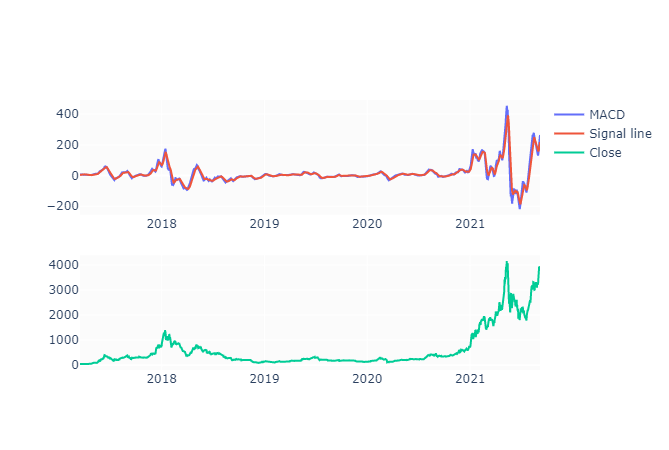

In [12]:
# Plottig MACD

plot_MACD(eth_df)

In [13]:
eth_df['Close'] = eth_df['Close'].shift(-1)
eth_df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2017-03-17  45.929501  55.114700  38.207001  34.160198  46.827999  497534016   
2017-03-18  46.874199  46.874199  31.702101  44.740101  34.160198  262180000   
2017-03-19  35.529701  46.995998  35.341599  43.390202  44.740101  239430000   
2017-03-20  44.833599  46.228901  42.444698  43.145100  43.390202  154700992   
2017-03-21  43.509800  44.262299  42.370701  42.342098  43.145100   91265400   

                SMA_5    SMA_10     SMA_15     SMA_30      EMA_9        RSI  \
Date                                                                          
2017-03-17  37.095440  28.41257  25.333346  19.689940  32.992228  93.234880   
2017-03-18  38.208899  30.16346  26.313426  20.398490  33.225822  63.633309   
2017-03-19  41.425999  32.86200  28.054840  21.467277  35.528678  71.711460   
2017-03-20  43.092860  35.26779  29.660700  22.486610  37.100983  69.587512   
2017-03-21  42.452720  37.43505  31.229993  23.499497  38.309806  69.186822   

                MACD  MACD Signal  
Date                               
2017-03-17  6.671575     3.871907  
2017-03-18  6.486793     4.394884  
2017-03-19  7.112078     4.938323  
2017-03-20  7.413240     5.433306  
2017-03-21  7.545160     5.855677

In [14]:
eth_df = eth_df[:-1]
eth_df.tail()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2021-09-01  3430.762451  3836.867432  3387.408447  3790.989990  3834.828125   
2021-09-02  3825.027832  3830.711426  3726.750488  3940.614746  3790.989990   
2021-09-03  3787.486572  4022.469238  3712.678223  3887.828369  3940.614746   
2021-09-04  3937.910156  3969.448730  3837.931152  3952.133545  3887.828369   
2021-09-05  3886.331055  3979.186523  3838.487305  3930.066162  3952.133545   

                 Volume        SMA_5       SMA_10       SMA_15       SMA_30  \
Date                                                                          
2021-09-01  30070890104  3392.868213  3305.189624  3267.321533  3157.091862   
2021-09-02  24387397330  3502.185547  3352.362891  3318.714876  3200.046541   
2021-09-03  26207765094  3644.907959  3429.178735  3369.242383  3240.579704   
2021-09-04  20806963328  3777.598779  3495.470044  3409.301921  3275.929688   
2021-09-05  18371468576  3881.278955  3580.650854  3457.705225  3311.302751   

                  EMA_9        RSI        MACD  MACD Signal  
Date                                                         
2021-09-01  3374.422056  73.254796  175.850263   160.760897  
2021-09-02  3457.735643  71.160740  199.608913   168.530500  
2021-09-03  3554.311463  73.902830  227.884373   180.401275  
2021-09-04  3621.014845  71.326213  243.229659   192.966952  
2021-09-05  3687.238585  72.580390  257.610229   205.895607

In [15]:
eth_df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2017-03-17  45.929501  55.114700  38.207001  34.160198  46.827999  497534016   
2017-03-18  46.874199  46.874199  31.702101  44.740101  34.160198  262180000   
2017-03-19  35.529701  46.995998  35.341599  43.390202  44.740101  239430000   
2017-03-20  44.833599  46.228901  42.444698  43.145100  43.390202  154700992   
2017-03-21  43.509800  44.262299  42.370701  42.342098  43.145100   91265400   

                SMA_5    SMA_10     SMA_15     SMA_30      EMA_9        RSI  \
Date                                                                          
2017-03-17  37.095440  28.41257  25.333346  19.689940  32.992228  93.234880   
2017-03-18  38.208899  30.16346  26.313426  20.398490  33.225822  63.633309   
2017-03-19  41.425999  32.86200  28.054840  21.467277  35.528678  71.711460   
2017-03-20  43.092860  35.26779  29.660700  22.486610  37.100983  69.587512   
2017-03-21  42.452720  37.43505  31.229993  23.499497  38.309806  69.186822   

                MACD  MACD Signal  
Date                               
2017-03-17  6.671575     3.871907  
2017-03-18  6.486793     4.394884  
2017-03-19  7.112078     4.938323  
2017-03-20  7.413240     5.433306  
2017-03-21  7.545160     5.855677

In [16]:
df_train_2019 = eth_df.loc['2017-01-01':'2018-12-31', :]
df_train_2019.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2017-03-17  45.929501  55.114700  38.207001  34.160198  46.827999  497534016   
2017-03-18  46.874199  46.874199  31.702101  44.740101  34.160198  262180000   
2017-03-19  35.529701  46.995998  35.341599  43.390202  44.740101  239430000   
2017-03-20  44.833599  46.228901  42.444698  43.145100  43.390202  154700992   
2017-03-21  43.509800  44.262299  42.370701  42.342098  43.145100   91265400   

                SMA_5    SMA_10     SMA_15     SMA_30      EMA_9        RSI  \
Date                                                                          
2017-03-17  37.095440  28.41257  25.333346  19.689940  32.992228  93.234880   
2017-03-18  38.208899  30.16346  26.313426  20.398490  33.225822  63.633309   
2017-03-19  41.425999  32.86200  28.054840  21.467277  35.528678  71.711460   
2017-03-20  43.092860  35.26779  29.660700  22.486610  37.100983  69.587512   
2017-03-21  42.452720  37.43505  31.229993  23.499497  38.309806  69.186822   

                MACD  MACD Signal  
Date                               
2017-03-17  6.671575     3.871907  
2017-03-18  6.486793     4.394884  
2017-03-19  7.112078     4.938323  
2017-03-20  7.413240     5.433306  
2017-03-21  7.545160     5.855677

In [17]:
df_train_2019.shape

(655, 14)

In [18]:
df_test_2019 = eth_df.loc['2019-01-01':'2019-12-31', :]
df_test_2019.shape

(365, 14)

In [19]:
x_train = df_train_2019.drop('Close', axis=1)
y_train = df_train_2019[['Close']]
x_test = df_test_2019.drop('Close', axis=1)
y_test = df_test_2019[['Close']]

In [20]:
# Preprocessing

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [21]:
### Trying LSTM model

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model_1 = Sequential()

number_units = 50
dropout_fraction = 0.1

# Layer 1
model_1.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (x_train.shape[1],1))
         )
model_1.add(Dropout(dropout_fraction))

# Layer 2
model_1.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model_1.add(Dropout(dropout_fraction))

# Layer 3
model_1.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model_1.add(Dropout(dropout_fraction))

model_1.add(Dense(1))

In [22]:
model_1.compile(optimizer="adam", loss="mean_squared_error")
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 13, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 13, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [23]:
epochs = 50
batch_size = 10
model_1.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
66/66 [==============================] - 3s 7ms/step - loss: 0.0102
Epoch 2/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 3/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 4/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0221
Epoch 5/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 6/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 7/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0163
Epoch 8/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 9/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0096
Epoch 10/50
66/66 [==============================] - 0s 6ms/step - loss: 0.0081
Epoch 11/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 12/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 13/50
66/66 [==============================

In [24]:
model_1.evaluate(x_test, y_test)

12/12 [==============================] - 1s 2ms/step - loss: 0.0030


0.002953886054456234

In [25]:
y_pred = model_1.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.0029538859264322207


In [26]:
df_test_2019.shape

(365, 14)

In [27]:
df_test_2019['Predicted Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

In [28]:
df_test_2019.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-01-01  133.418152  141.397507  132.650711  155.047684  140.819412   
2019-01-02  141.519516  156.929138  140.650955  149.135010  155.047684   
2019-01-03  155.196045  155.863052  147.198364  154.581940  149.135010   
2019-01-04  148.912888  156.878983  147.907104  155.638596  154.581940   
2019-01-05  154.337418  160.824890  154.337418  157.746201  155.638596   

                Volume       SMA_5      SMA_10      SMA_15      SMA_30  \
Date                                                                     
2019-01-01  2258709868  137.942496  133.900163  125.590351  109.491198   
2019-01-02  3328240369  141.422629  136.328406  129.186033  111.028621   
2019-01-03  2676164880  143.645963  137.218106  132.377129  112.325981   
2019-01-04  3126192535  146.590460  139.691866  134.934800  114.062861   
2019-01-05  3338211928  151.044528  142.069162  138.010957  116.192112   

                 EMA_9        RSI       MACD  MACD Signal  Predicted Close  
Date                                                                        
2019-01-01  132.209460  60.030038   6.340204     2.402243       217.598160  
2019-01-02  136.777105  65.485401   7.943837     3.510562       236.779907  
2019-01-03  139.248686  61.715740   8.638051     4.536060       227.982605  
2019-01-04  142.315336  63.784026   9.518024     5.532453       236.123413  
2019-01-05  144.979988  64.188213  10.183285     6.462619       240.159775

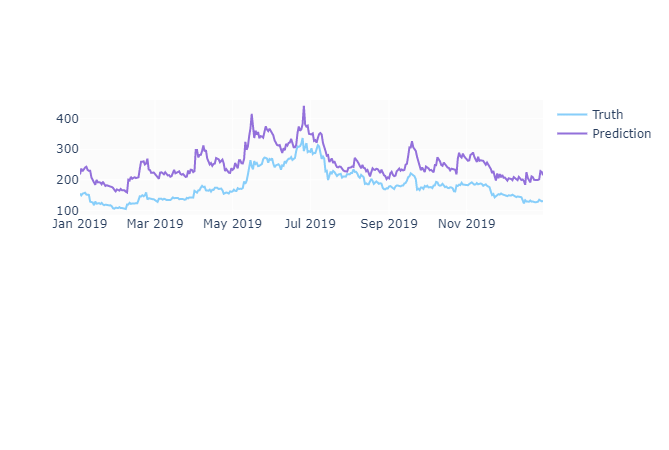

In [29]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df_test_2019.index, y=df_test_2019['Close'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_test_2019.index,
                         y=df_test_2019['Predicted Close'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()

#################

In [30]:
df_train_2021 = eth_df.loc['2019-01-01':'2020-12-31', :]
df_train_2021.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-12-27  635.887146  711.393555  628.334961  730.397339  682.642334   
2020-12-28  683.205811  745.877747  683.205811  731.520142  730.397339   
2020-12-29  730.358704  737.952881  692.149414  751.618958  731.520142   
2020-12-30  731.472839  754.303223  720.988892  737.803406  751.618958   
2020-12-31  751.626648  754.299438  726.511902  730.367554  737.803406   

                 Volume       SMA_5      SMA_10      SMA_15      SMA_30  \
Date                                                                      
2020-12-27  26093552821  628.042126  633.728339  625.424276  602.487730   
2020-12-28  24222565862  657.378674  641.286877  634.806551  608.893315   
2020-12-29  18710683199  681.361267  648.509100  644.507149  614.085384   
2020-12-30  17294574210  706.402917  659.841913  655.324707  618.644598   
2020-12-31  13926846861  726.796436  672.640466  662.099479  623.660573   

                 EMA_9        RSI       MACD  MACD Signal  
Date                                                       
2020-12-27  633.430439  63.693631  23.943755    23.395733  
2020-12-28  652.823819  68.777808  30.334596    24.783505  
2020-12-29  668.563083  68.888123  35.085541    26.843912  
2020-12-30  685.174258  70.872075  40.011280    29.477386  
2020-12-31  695.700088  67.677369  42.312413    32.044391

In [31]:
df_test_2021 = eth_df.loc['2021-01-01':'2021-09-06', :]
df_test_2021.head()

Open         High         Low        Close    Adj Close  \
Date                                                                         
2021-01-01   737.708374   749.201843  719.792236   774.534973   730.367554   
2021-01-02   730.402649   786.798462  718.109497   975.507690   774.534973   
2021-01-03   774.511841  1006.565002  771.561646  1040.233032   975.507690   
2021-01-04   977.058838  1153.189209  912.305359  1100.006104  1040.233032   
2021-01-05  1041.498779  1129.371460  986.811279  1207.112183  1100.006104   

                 Volume       SMA_5      SMA_10      SMA_15      SMA_30  \
Date                                                                      
2021-01-01  13652004358  736.341479  682.191803  667.932719  628.061080   
2021-01-02  19740771179  745.169006  701.273840  675.914254  633.321954   
2021-01-03  45200463368  793.966516  737.663892  696.994906  646.860404   
2021-01-04  56945985763  851.689331  779.046124  723.791052  661.648324   
2021-01-05  41535932781  924.129871  825.463153  756.470268  678.251560   

                 EMA_9        RSI        MACD  MACD Signal  
Date                                                        
2021-01-01  702.633581  65.954132   43.039929    34.243499  
2021-01-02  717.013859  70.722705   46.642763    36.723352  
2021-01-03  768.712626  82.638630   64.965967    42.371875  
2021-01-04  823.016707  84.786239   83.744675    50.646435  
2021-01-05  878.414586  86.452853  102.271206    60.971389

In [32]:
x_train = df_train_2021.drop('Close', axis=1)
y_train = df_train_2021[['Close']]
x_test = df_test_2021.drop('Close', axis=1)
y_test = df_test_2021[['Close']]

In [33]:
# Preprocessing

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [34]:
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [35]:
epochs = 50
batch_size = 10
model_1.fit(x_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 2/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 3/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 4/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 5/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 6/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 7/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 8/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 9/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 10/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 11/50
73/73 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 12/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 13/50
73/73 [==============================

In [36]:
model_1.evaluate(x_test, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 4.7626


4.762572288513184

In [37]:
y_pred = model_1.predict(x_test)
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 4.762572458181163


In [38]:
df_test_2021['Predicted Close'] = scaler.inverse_transform(y_pred.reshape(-1,1))

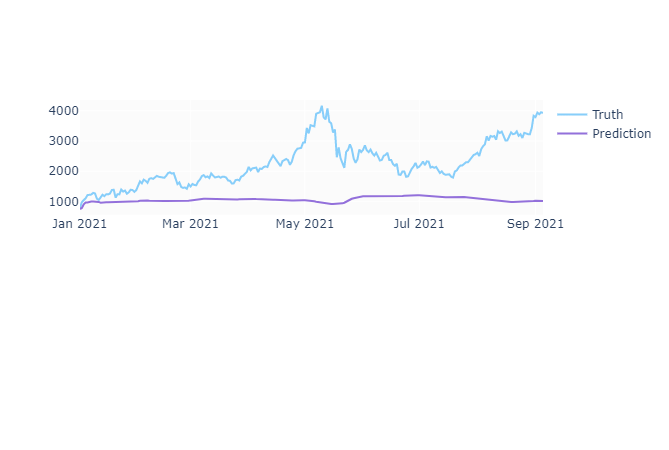

In [39]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df_test_2021.index, y=df_test_2021['Close'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_test_2021.index,
                         y=df_test_2021['Predicted Close'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()

In [40]:
df = pd.read_csv('ETH-USD_stock_prices.csv', index_col='Date', parse_dates=True)
get_moving_averages(df)
get_RSI(df)
get_MACD(df)
inp = df[-1:].drop('Close', axis=1)
inp

Open         High          Low    Adj Close       Volume  \
Date                                                                          
2021-09-06  3948.682129  3966.984131  3868.994385  3930.066162  18899175424   

                  SMA_5       SMA_10       SMA_15       SMA_30      EMA_9  \
Date                                                                        
2021-09-06  3900.326562  3646.597388  3503.568604  3337.063664  3735.8041   

                  RSI        MACD  MACD Signal  
Date                                            
2021-09-06  71.425824  264.180967   217.552679

In [41]:
inp = np.array(inp)
inp = inp.reshape((inp.shape[0], inp.shape[1], 1))
tomorrow = model_1.predict(inp)
scaler.inverse_transform(tomorrow)

array([[873.7914]], dtype=float32)